## **공분산 계산 procedure**

1. spacetrack 에서 tle 가져오기 (14일 동안의 tle 수집)</br>
2. 가장 최근의 tle propagated position과의 residual 계산 후 </br>
   RIC, NTW 좌표계로 변환</br>
3. 변환된 residual의 분산 계산 => 공분산


## **import**

In [1]:
from sgp4.api import Satrec, jday
import numpy as np
from datetime import datetime
import json
import configparser
import requests
from matplotlib import pyplot as plt

## **function**

In [3]:
# ECI 좌표를 NTW로 변환
def calculate_trasformation_matrix_eci_to_ntw(true_position, true_velocity):
    t_axis = true_velocity/np.linalg.norm(true_velocity)

    rv_eci = np.cross(true_position, true_velocity)
    w_axis = rv_eci/np.linalg.norm(rv_eci)

    n_axis = np.cross(t_axis,w_axis)

    trasformation_matrix_ntw =(np.vstack((t_axis, n_axis, w_axis)))

    return trasformation_matrix_ntw

# ECI 좌표를 RSW로 변환
def calculate_trasformation_matrix_eci_to_rsw(true_position, true_velocity):
    r_axis = true_position/np.linalg.norm(true_position)
    rv_eci = np.cross(true_position, true_velocity)
    w_axis = rv_eci/np.linalg.norm(rv_eci)
    s_axis=np.cross(w_axis,r_axis)

    trasformation_matrix_rsw = (np.vstack((r_axis, s_axis, w_axis)))
    return trasformation_matrix_rsw
   
# string을 datetime으로 변환
def str_to_datetime(date_str):

    return datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')

# TLE데이터를 통해 datetime시점에서의 statevector 계산
def get_state_ECI(epoch_datetime, tle_line1, tle_line2):

    yr, mon, day = epoch_datetime.year, epoch_datetime.month, epoch_datetime.day
    hour, min, sec = epoch_datetime.hour, epoch_datetime.minute, epoch_datetime.second
    jd, fr = jday(yr, mon, day, hour, min, sec)

    satellite = Satrec.twoline2rv(tle_line1,tle_line2) 
    e, r, v = satellite.sgp4(jd,fr)
    position_np=np.array(r)
    velocity_np=np.array(v)
    return position_np, velocity_np

# spack-track TLE 주소를 알고 있는 상태에서 특정 feature 불러오기
def get_tle_element(feature, uri_base="https://www.space-track.org", request_login = "/ajaxauth/login", request_cmd_action = "/basicspacedata/query"):
    param=feature
    # set of satellite ids of objects included in TLE data
    SATNO_LIST = []

    # Use configparser package to pull in the ini file (pip install configparser)
    config = configparser.ConfigParser()
    config.read("./Login.ini")
    configUsr = config.get("configuration", "username")
    configPwd = config.get("configuration", "password")
    siteCred = {'identity': configUsr, 'password': configPwd}

    with requests.Session() as session:
        # run the session in a with block to force session to close if we exit

        # need to log in first. note that we get a 200 to say the web site got the data, not that we are logged in
        response = session.post(uri_base + request_login, data=siteCred)
        if response.status_code != 200:
            print("Error, POST fail on login")

        # this query picks up objects from the catalog. Note - a 401 failure shows you have bad credentials
        response = session.get(uri_base + request_cmd_action + request_find_objects)
        if response.status_code != 200:
            print("Error, GET fail on request")

        data = json.loads(response.text)
        for object in data:
            SATNO = object[f'{feature}']
            SATNO_LIST.append(SATNO)
    
        session.close()
        SATNO_LIST=np.array(SATNO_LIST).reshape(-1,1)
    return list(SATNO_LIST.flatten()) 

# 상삼각행렬 부분만 추출
def upper_triangular_matrix_to_list(matrix):
    # 행렬의 차원 (행과 열의 수) 가져오기
    num_rows, num_cols = len(matrix), len(matrix[0])

    upper_triangular_elements = []
    for i in range(num_rows):
        for j in range(i, num_cols):  # 주 대각선과 그 위의 요소만 저장
            upper_triangular_elements.append(matrix[i][j])

    return upper_triangular_elements

# MAPE
def calculate_mape(actual, pred):
    if len(actual) != len(pred):
        raise ValueError("두 리스트는 길이가 동일해야 합니다.")

    n = len(actual)
    sum_percentage_errors = 0

    for i in range(n):
        if actual[i] != 0:  # 분모가 0이 아닌 경우에만 오차를 계산
            absolute_error = abs(actual[i] - pred[i])
            percentage_error = (absolute_error / actual[i]) * 100
            sum_percentage_errors += percentage_error

    mape = sum_percentage_errors / n
    return mape

## **example satellite TLE data url**

In [7]:
uri_base = "https://www.space-track.org"
request_login = "/ajaxauth/login"
global request_cmd_action 
request_cmd_action = "/basicspacedata/query"

KOMPSAT-2

In [240]:
norad_cat_id = 29268   
start_date = "2011-09-12" 
end_date = "2011-09-27" 
global request_find_objects
request_find_objects = f"/class/tle/EPOCH/>{start_date}%2C<{end_date}/NORAD_CAT_ID/{norad_cat_id}/orderby/EPOCH%20asc"


LAGEOS -1

In [4]:
norad_cat_id = 8820  
start_date = "2003-03-01" 
end_date = "2003-03-16"
global request_find_objects
request_find_objects = f"/class/tle/EPOCH/>{start_date}%2C<{end_date}/NORAD_CAT_ID/{norad_cat_id}/orderby/EPOCH%20asc"


HEO

In [154]:
norad_cat_id = 28544  
start_date = "2015-11-09" 
end_date = "2015-11-24" 
request_find_objects = r= f"/class/tle/EPOCH/>{start_date}%2C<{end_date}/NORAD_CAT_ID/{norad_cat_id}/orderby/EPOCH%20asc"

LEO

In [61]:
norad_cat_id=22675 
start_date="2015-11-09" 
end_date="2015-11-24" 
global request_find_objects
request_find_objects = f"/class/tle/EPOCH/>{start_date}%2C<{end_date}/NORAD_CAT_ID/{norad_cat_id}/orderby/EPOCH%20asc"


##  **get historical TLE data**

In [5]:
epoch = get_tle_element("EPOCH")
tle_line1 = get_tle_element("TLE_LINE1")
tle_line2 = get_tle_element("TLE_LINE2")

epoch_datetime = np.vectorize(str_to_datetime)(epoch) 

## **좌표계 변환**</br>
calculate_trasformation_matrix_eci_to_rsw : RSW 좌표계로의 변환행렬 생성</br>
calculate_trasformation_matrix_eci_to_ntw : RSW 좌표계로의 변환행렬 생성

In [244]:
recent_epoch = epoch_datetime[-1] # 가장 최근시점을 기준으로 삼음
N = epoch_datetime.size 
position_residual_list =[]
state_vector_list = []
true_position, true_velocity = get_state_ECI(recent_epoch, tle_line1[-1], tle_line2[-1])
tranformation_matrix_rsw = calculate_trasformation_matrix_eci_to_rsw(true_position, true_velocity)

for i in range(N-1): 
    current_position, current_velocity = get_state_ECI(recent_epoch, tle_line1[i], tle_line2[i])
    position_residual = current_position-true_position
    velocity_residual = current_velocity-true_velocity

    state_matrix_rsw = tranformation_matrix_rsw @ np.transpose(np.vstack((position_residual,velocity_residual)))

    position_rsw ,velocity_rsw= state_matrix_rsw[:,0], state_matrix_rsw[:,1]
  
    state_vector = position_rsw.tolist()
    state_vector.extend(velocity_rsw.tolist())
    state_vector_list.append(state_vector)


    position_residual_list.append((tuple(position_rsw))) 
   

## **공분산 계산**

In [245]:
covariance = np.transpose(state_vector_list - np.mean(state_vector_list,axis=0))@(state_vector_list - np.mean(state_vector_list,axis=0))/len(state_vector_list)
#공분산 출력하기
for i in range(covariance.shape[0]):
    for j in range(covariance.shape[1]):
        print(f'{covariance[i,j]}   ',end="")
    print('\n')

0.03355965597589561   0.4179412913695162   -0.038041029863396116   -0.00046196376200459627   -3.6561156816757826e-05   -1.5248246977193373e-05   

0.4179412913695162   18.830082059218334   -0.49901866027017644   -0.02030026128354143   -0.0004831327045917514   -0.0002540933404550569   

-0.038041029863396116   -0.49901866027017644   0.045994422298648835   0.0005492720653050179   4.1511924876250024e-05   1.6388766240420976e-05   

-0.00046196376200459627   -0.02030026128354143   0.0005492720653050179   2.1891857769063743e-05   5.329758339638116e-07   2.793890616170367e-07   

-3.6561156816757826e-05   -0.0004831327045917514   4.1511924876250024e-05   5.329758339638116e-07   3.990759482446801e-08   1.6755156405070373e-08   

-1.5248246977193373e-05   -0.0002540933404550569   1.6388766240420976e-05   2.793890616170367e-07   1.6755156405070373e-08   8.659652194394976e-09   



## **MAPE 계산 ( 상삼각행렬 요소만 )**

In [205]:
# 상삼각행렬의 요소만 리스트로 변환
cov1=upper_triangular_matrix_to_list(covariance)

# 논문 계산 결과
Komsat2_covariance = [0.034238,0.42645,-0.03883,-0.00047,-3.73e-05,-1.55e-05,19.222,-0.50948,-0.02072,-0.00049,-0.00026,\
                  4.70e-02,0.00056,4.24e-05,1.67e-5,2.23e-5,5.44e-07,2.85e-07,\
                    4.07e-08,1.71e-08,8.81e-09]
Lageous_covariance=[0.378619709,-0.034359821,0.027715274,1.5511e-05,-0.000171498,-1.90966e-05,0.004002483,-0.002717183,\
                    -1.81855e-06,1.5463e-05,1.89775e-06,0.008430228,1.22177e-06,-1.21872e-05,-5.33055e-06,8.26397e-10,\
                        -6.9792e-09,-8.54481e-10,7.79043e-08,8.3125e-09,3.77679e-09]

# 논문계산결과와 비교해 MAPE 계산
print(f'MAPE:{round(calculate_mape(Lageous_covariance, cov1),4)}')

MAPE:0.0118


## **axis 별 residual variation Scatter**

In [ ]:
recent_epoch = epoch_datetime[-1] # 가장 최근시점을 기준으로 삼음
N = epoch_datetime.size 
position_residual_list =[]
state_vector_list = []
true_position, true_velocity = get_state_ECI(recent_epoch, tle_line1[-1], tle_line2[-1])
tranformation_matrix_rsw = calculate_trasformation_matrix_eci_to_rsw(true_position, true_velocity)

for i in range(N-1): 
    current_position, current_velocity = get_state_ECI(recent_epoch, tle_line1[i], tle_line2[i])
    position_residual = current_position-true_position
    velocity_residual = current_velocity-true_velocity

    state_matrix_rsw = tranformation_matrix_rsw @ np.transpose(np.vstack((position_residual,velocity_residual)))

    position_rsw ,velocity_rsw= state_matrix_rsw[:,0], state_matrix_rsw[:,1]
  
    state_vector = position_rsw.tolist()
    state_vector.extend(velocity_rsw.tolist())
    state_vector_list.append(state_vector)


    position_residual_list.append((tuple(position_rsw))) 

In [257]:
N = epoch_datetime.size #총 TLE 개수 24개 
np.set_printoptions(formatter={'float': lambda x: "{:.12f}".format(x)})
position_residual_list =[]
time_delta_list = []
for i in range(N-1,-1,-1): # 기준 시점은 제외.
    recent_epoch = epoch_datetime[i]
    true_position, true_velocity = get_state_ECI(recent_epoch, tle_line1[i], tle_line2[i])
    tranformation_matrix = calculate_trasformation_matrix_eci_to_rsw(true_position,true_velocity)
    for j in range(i-1):
        current_epoch = epoch_datetime[j]
        time_delta = recent_epoch -current_epoch
        time_delta_list.append(time_delta.days+time_delta.seconds/(3600)/24) #시간구하고

        current_position, current_velocity = get_state_ECI(recent_epoch,tle_line1[j], tle_line2[j])
        position_residual = current_position-true_position
        velocity_residual = current_velocity-true_velocity
  
        state_matrix_rsw = tranformation_matrix @ np.transpose(np.vstack((position_residual,velocity_residual)))
        position_rsw ,velocity_rsw= state_matrix_rsw[:,0], state_matrix_rsw[:,1]
  
        position_rsw=tuple(position_rsw)
        position_residual_list.append((position_rsw)) 

In [258]:
radial = [arr[0] for arr in position_residual_list]
in_track = [arr[1] for arr in position_residual_list]
cross_track = [arr[2] for arr in position_residual_list]

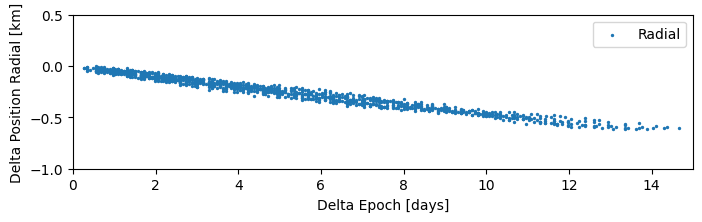

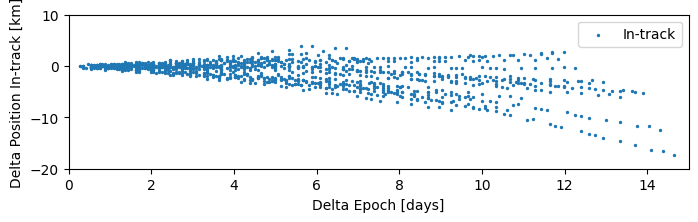

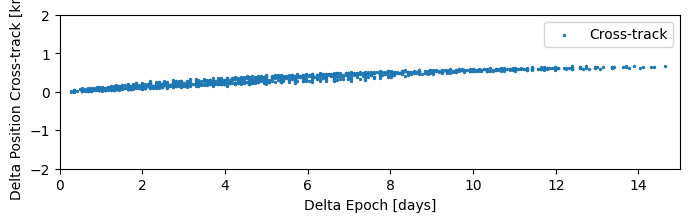

In [264]:
def plot_scatter(time_delta_list, data, y_label, y_limits):
    plt.figure(figsize=(8, 2))
    plt.scatter(time_delta_list, data, s=2, label=y_label)
    plt.xlim(0, 15)
    plt.ylim(*y_limits)
    plt.xlabel("Delta Epoch [days]")
    plt.ylabel(f"Delta Position {y_label} [km]")
    plt.legend()
plot_scatter(time_delta_list, radial, "Radial", (-1, 0.5))
plot_scatter(time_delta_list, in_track, "In-track", (-20, 10))
plot_scatter(time_delta_list, cross_track, "Cross-track", (-2, 2))

plt.show()